In [1]:
import tensorflow as tf
import pandas as pd
import os, time, itertools, imageio, pickle, random
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import one_hot, resize_to_ori_calMRE, resize_to_ori


tf.reset_default_graph() 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPU

C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\tensorflow\pyth

In [2]:
folder = 'election_VAE_alt3/'
gen_results = 'generated_results/'

model = 'model_'+'.ckpt'

if not os.path.isdir(folder):
    os.mkdir(folder)
    
if not os.path.isdir(folder + gen_results):
    os.mkdir(folder + gen_results)

# save ckpt
saver_path = os.path.join(folder, model)

# read ckpt
restore_path = os.path.join(folder)

# save generated data
generated_path = os.path.join(folder + gen_results)

In [3]:
# one hot code
def one_hot ( labels , Label_class ): 
    one_hot_label = np.array([[ int (i == int (labels[j])) for i in range (Label_class)] for j in range ( len (labels))])      
    return one_hot_label

In [4]:
img_width = 30
img_height = 24

data_alt3 = pd.read_csv('./data/netflix_data_3alt_resize.csv')
data_alt3 = data_alt3.iloc[:1000,1:].values

data_alt3 = data_alt3.reshape([-1, img_height, img_width])
print(data_alt3.shape)

##################################
data_alt4 = pd.read_csv('./data/netflix_data_4alt_resize.csv')
data_alt4 = data_alt4.iloc[:1000,1:].values

data_alt4 = data_alt4.reshape([-1, img_height, img_width])
print(data_alt4.shape)

# data_alt_3_4 = np.concatenate( (data_alt3, data_alt4), axis = 0)
# print(data_alt_3_4.shape) 

data_alt_3_4 = data_alt3

(1000, 24, 30)
(1000, 24, 30)


In [5]:
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt3[2], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(data_alt4[99], (data_alt3.shape[1], data_alt3.shape[2])), cmap='gray')

In [6]:
np.random.seed(0)
np.random.shuffle(data_alt_3_4)

In [7]:
class election_VAE(object):
    def __init__(self,
                num_samples = None,
                dim_height = None,
                dim_width = None,
                dim_z = None,
                num_class = None,
                batch_size = None,
                _reuse = None):
        
        # Definition Params:
        self.num_samples = num_samples  
        self.dim_height = dim_height    
        self.dim_width = dim_width  
        self.dim_z = dim_z    
        self.num_class = num_class      
        self.batch_size = batch_size  

        # Define Network Input:
        self.X = tf.placeholder(tf.float32, shape=(self.batch_size, self.dim_height, self.dim_width, 1))
#         self.Z = tf.placeholder(tf.float32, shape=(self.batch_size, 1, 1, self.dim_z))
        self.Z = tf.placeholder(tf.float32, shape=(self.batch_size*self.dim_z))
        self.Y_label = tf.placeholder(tf.float32, shape=(self.batch_size, 1, 1, self.num_class))
        self.Y_fill = tf.placeholder(tf.float32, shape=(self.batch_size, self.dim_height, self.dim_width, self.num_class))
        self.isTrain = tf.placeholder(dtype=tf.bool)
        self.keep_prob_feed = tf.placeholder(tf.float32)
        self.global_step = tf.Variable(0, trainable = False)
        
        # Network:
        self._decoder(self.Z, self.keep_prob_feed)
        
        self._encoder(self.X, self.keep_prob_feed)
        
        with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
            self._object_cost_function()        
        
    def _decoder(self, Z, keep_prob_feed):

        with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
            dim = 128

            # concat layer
#             Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
            Z_ = tf.reshape(Z, (-1, self.dim_z))        

            # FCN 
            hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)
            hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

            # CNN 1 
            hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)

            # CNN 2 
            hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
            hidden = tf.nn.relu(hidden)     

            # CNN 3 
            hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
            output = hidden

            return output     
    
    def _encoder(self, X, keep_prob_feed):

        with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
            dim = 128
            leak = 0.2
            # concat layer
#             X_ = tf.concat([X, Y_fill], 3)  #(batch_size, dim_height, dim_width, channel + num_class)
            X_ = X

            # CNN 1 
            hidden = tf.layers.conv2d(X_, 1*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 2 
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # CNN 3
            hidden = tf.layers.conv2d(hidden, 2*dim, [4, 5], strides=(2, 2), padding='same', use_bias=False)
            hidden = ((0.5 * (1 + leak)) * hidden) + ((0.5 * (1 - leak)) * tf.abs(hidden)) #lrelu

            # Flatten layer
            hidden = tf.layers.flatten(hidden)        
            hidden = tf.layers.dense(hidden, units = self.dim_z)
            hidden = tf.reshape(hidden, (-1, 1)) 
#             print(hidden.shape)
            
            mean = hidden
            std = tf.nn.softplus(hidden) + 1e-6            

            return mean, std    
    
    def _object_cost_function(self):
        
        # MODEL
        mean, std = self._encoder(self.X, self.keep_prob_feed)

        eps = tf.random_normal(tf.shape(mean, out_type = tf.int32), 0, 1, dtype = tf.float32)
        self.Z = mean + std*eps  
        print(self.Z.shape)
        
        generated_output = self._decoder(self.Z, self.keep_prob_feed)
        
        self.real_data = self.X
        self.fake_data = generated_output
            
        # Recon_error
        self.Recon_error = tf.losses.mean_squared_error(self.real_data, self.fake_data)

        # KL_divergence
        KL_Divergence = tf.reduce_mean(0.5*tf.reduce_sum(1 - tf.log(tf.square(std) + 1e-8) 
                                                         + tf.square(mean) + tf.square(std), 1))
        Regularization_error = KL_Divergence

        # ELBO_error
        self.ELBO = self.Recon_error + Regularization_error
        
        learning_rate = 0.0001
        self.optim = tf.train.AdamOptimizer(learning_rate).minimize(self.ELBO)
        
            
    def train_model(self,
                    x_train = None,     
                    keep_prob = None,
                    train_epoch = None, 
                    n_critic = 5,
                    step_valid = 50,
                    step_save_data = 500, #500
                    iteration_generator = 50,
                   ): 
        
        self.train_hist = {}
        self.train_hist['Recon_e_list'] = []
        self.train_hist['ELBO_e_list'] = []

        saver = tf.train.Saver()
        
        session_config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth=True))
        with tf.Session(config = session_config) as sess:
            sess.run(tf.global_variables_initializer())
            print('Optimization start!')

            for epoch in range(train_epoch):
                Recon_e_list = []
                ELBO_e_list = []

                time_start_epoch = time.time()
                
                for i in range(len(x_train) // self.batch_size): # num_samples / batch_size
                    '''#############        Discriminator       #######################'''
                    x_ = x_train[i*self.batch_size: (i+1)*self.batch_size] 
                    x_ = x_.reshape((self.batch_size, self.dim_height, self.dim_width, 1))   #(batch_size, dim_height, dim_width, 1)

                    _, ELBO, Recon_error  = sess.run([self.optim, self.ELBO, self.Recon_error], 
                                          feed_dict={self.X: x_, 
                                                     self.keep_prob_feed: keep_prob,
                                                     self.isTrain: True})
                    ELBO_e_list.append(ELBO)
                    Recon_e_list.append(Recon_error)

            ############        print result      #######################
                if (epoch+1) % 1 == 0:
                    print('[%d/%d] Recon_e: %.3f, ELBO_e: %.3f'%((epoch + 1), train_epoch, np.mean(ELBO_e_list), np.mean(Recon_e_list)))
                    self.train_hist['Recon_e_list'].append(np.mean(ELBO_e_list))
                    self.train_hist['ELBO_e_list'].append(np.mean(Recon_e_list))

            ############        valid      #######################
                if (epoch+1) % step_valid == 0:
                    z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z)).reshape([-1,1]) 

                    output_g_alt = sess.run([self.fake_data], 
                                          feed_dict={self.Z: z_, 
                                                     self.keep_prob_feed: 1,
                                                     self.isTrain: False})    
                    output_g_alt_ = np.array(output_g_alt).reshape([self.batch_size, self.dim_height, self.dim_width])[0]

                    plt.figure(epoch)
                    fig, ax = plt.subplots(figsize=(5, 5))
                    ax.cla()
                    ax.imshow(np.reshape(output_g_alt_, (self.dim_height, self.dim_width)), cmap='gray')

            ############        save per 1000 epoch      #######################
                if (epoch+1) % step_save_data == 0:
                    
                    generated_alt = []
                    for _ in range(iteration_generator):  
                        z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z)).reshape([-1,1]) 

                        output_g_alt = sess.run([self.fake_data], 
                                                        feed_dict={self.Z: z_, 
                                                        self.keep_prob_feed: 1,
                                                        self.isTrain: False})    
                        generated_alt.append(np.array(output_g_alt).reshape([self.batch_size, self.dim_height, self.dim_width]))

                    generated_alt = np.array(generated_alt).reshape([iteration_generator*self.batch_size, self.dim_height, self.dim_width])
                  
                    gen_alt_ori = resize_to_ori(generated_alt, np.math.factorial(6), 30, 24, np.math.factorial(3), self.batch_size, iteration_generator)
                    gen_alt_pd = pd.DataFrame(gen_alt_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
                    gen_alt_pd.to_csv(generated_path + 'generated_atl3_' + str(epoch) + '.csv')                    
                    
                time_end_epoch = time.time()
                print('Time cost in one epoch', time_end_epoch - time_start_epoch,'s') 
                    
            ###########        save      #######################
            saver.save(sess, saver_path)   
            print('save success')
        
            sess.close()

        print("Optimization Finished!")
        
    '''loss curve'''
    def show_train_hist(self):
        x = range(len(self.train_hist['Recon_e_list']))

        y1 = self.train_hist['Recon_e_list']
        y2 = self.train_hist['ELBO_e_list']

        plt.plot(x, y1, label='Recon_e_list')
        plt.plot(x, y2, label='ELBO_e_list')

        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.legend(loc=4)  
        plt.grid(True)
        plt.tight_layout() 
        plt.title("Training Losses")

        plt.show()


In [8]:
num_samples = data_alt_3_4.shape[0]
dim_height = data_alt_3_4.shape[1]
dim_width = data_alt_3_4.shape[2]
dim_z = 128
num_class = 2
batch_size = 50

In [9]:
model = election_VAE(
                num_samples = num_samples,
                dim_height = dim_height,
                dim_width = dim_width,
                dim_z = dim_z,
                num_class = num_class,
                batch_size = batch_size)


(6400, 1)


Optimization start!
[1/5000] Recon_e: 1.125, ELBO_e: 0.045
Time cost in one epoch 1.897925615310669 s
[2/5000] Recon_e: 1.094, ELBO_e: 0.029
Time cost in one epoch 0.44880008697509766 s
[3/5000] Recon_e: 1.088, ELBO_e: 0.024
Time cost in one epoch 0.4478025436401367 s
[4/5000] Recon_e: 1.086, ELBO_e: 0.022
Time cost in one epoch 0.44780468940734863 s
[5/5000] Recon_e: 1.085, ELBO_e: 0.022
Time cost in one epoch 0.4478027820587158 s
[6/5000] Recon_e: 1.085, ELBO_e: 0.022
Time cost in one epoch 1.339418649673462 s
[7/5000] Recon_e: 1.085, ELBO_e: 0.022
Time cost in one epoch 0.5016570091247559 s
[8/5000] Recon_e: 1.085, ELBO_e: 0.022
Time cost in one epoch 0.4857032299041748 s
[9/5000] Recon_e: 1.085, ELBO_e: 0.021
Time cost in one epoch 1.8699989318847656 s
[10/5000] Recon_e: 1.085, ELBO_e: 0.021
Time cost in one epoch 0.4527907371520996 s
[11/5000] Recon_e: 1.085, ELBO_e: 0.021
Time cost in one epoch 1.8071677684783936 s
[12/5000] Recon_e: 1.085, ELBO_e: 0.021
Time cost in one epoch 0.

[99/5000] Recon_e: 1.083, ELBO_e: 0.016
Time cost in one epoch 0.4886939525604248 s
[100/5000] Recon_e: 1.083, ELBO_e: 0.016
Time cost in one epoch 0.4827089309692383 s
[101/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.9069015979766846 s
[102/5000] Recon_e: 1.083, ELBO_e: 0.016
Time cost in one epoch 0.4398233890533447 s
[103/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.9059035778045654 s
[104/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.45977091789245605 s
[105/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.831104040145874 s
[106/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.48171305656433105 s
[107/5000] Recon_e: 1.082, ELBO_e: 0.016
Time cost in one epoch 1.780240535736084 s
[108/5000] Recon_e: 1.082, ELBO_e: 0.016
Time cost in one epoch 0.49068689346313477 s
[109/5000] Recon_e: 1.082, ELBO_e: 0.016
Time cost in one epoch 0.44581007957458496 s
[110/5000] Recon_e: 1.083, ELBO_e: 0.016
Time cost in one epoch 

[196/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.880972146987915 s
[197/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.4548051357269287 s
[198/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.7862029075622559 s
[199/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.4777219295501709 s
[200/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.8350937366485596 s
[201/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.47572827339172363 s
[202/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.8041772842407227 s
[203/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.48968935012817383 s
[204/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 1.8261182308197021 s
[205/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.5006616115570068 s
[206/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.44580721855163574 s
[207/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch

[293/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 0.4527881145477295 s
[294/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.9278643131256104 s
[295/5000] Recon_e: 1.082, ELBO_e: 0.015
Time cost in one epoch 0.4557628631591797 s
[296/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 1.8261170387268066 s
[297/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.4767310619354248 s
[298/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.7742559909820557 s
[299/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 0.5056421756744385 s
[300/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8700003623962402 s
[301/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 0.49767041206359863 s
[302/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.4468057155609131 s
[303/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8979244232177734 s
[304/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 

[390/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.49503302574157715 s
[391/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.45102596282958984 s
[392/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8515217304229736 s
[393/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 0.45378708839416504 s
[394/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.816702127456665 s
[395/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.47914719581604004 s
[396/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 1.7902123928070068 s
[397/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.49581432342529297 s
[398/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8397631645202637 s
[399/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.49818897247314453 s
[400/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.48669862747192383 s
[401/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one e

[487/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.7808361053466797 s
[488/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.5036513805389404 s
[489/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4617655277252197 s
[490/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8281137943267822 s
[491/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5016734600067139 s
[492/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.9449520111083984 s
[493/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.46475887298583984 s
[494/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8340961933135986 s
[495/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4728543758392334 s
[496/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8740553855895996 s
[497/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4966728687286377 s
[498/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 

C:\Users\WIN10\anaconda3\envs\tf1.12\lib\site-packages\ipykernel_launcher.py:184: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[551/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.7992851734161377 s
[552/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.4857034683227539 s
[553/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8281099796295166 s
[554/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.4857015609741211 s
[555/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.823324203491211 s
[556/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5157492160797119 s
[557/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.45391225814819336 s
[558/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8892040252685547 s
[559/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4607682228088379 s
[560/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.824213981628418 s
[561/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.47273683547973633 s
[562/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1

[648/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.893366813659668 s
[649/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.4667501449584961 s
[650/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.9547748565673828 s
[651/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4659605026245117 s
[652/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8811204433441162 s
[653/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.48769402503967285 s
[654/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.8154094219207764 s
[655/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4886929988861084 s
[656/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1.7912111282348633 s
[657/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.5116324424743652 s
[658/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4527888298034668 s
[659/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 1

[745/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2573025226593018 s
[746/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6113660335540771 s
[747/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2562143802642822 s
[748/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.62831711769104 s
[749/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.5046541690826416 s
[750/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.758415460586548 s
[751/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3187947273254395 s
[752/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5495374202728271 s
[753/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 2.268357753753662 s
[754/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5834441184997559 s
[755/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.360684394836426 s
[756/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5834

[843/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.258558511734009 s
[844/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5748298168182373 s
[845/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.253232002258301 s
[846/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6226568222045898 s
[847/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 2.2916579246520996 s
[848/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.6033892631530762 s
[849/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 2.2713212966918945 s
[850/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.7820990085601807 s
[851/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2928690910339355 s
[852/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6043882369995117 s
[853/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3268067836761475 s
[854/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5

[940/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.0435328483581543 s
[941/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4667518138885498 s
[942/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.876511573791504 s
[943/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4769163131713867 s
[944/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.7802412509918213 s
[945/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4886925220489502 s
[946/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4438152313232422 s
[947/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8211307525634766 s
[948/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.44780397415161133 s
[949/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.7754826545715332 s
[950/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5166091918945312 s
[951/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1

[1036/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.7889418601989746 s
[1037/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5058419704437256 s
[1038/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.774632215499878 s
[1039/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5043168067932129 s
[1040/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4478013515472412 s
[1041/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.9374895095825195 s
[1042/5000] Recon_e: 1.081, ELBO_e: 0.014
Time cost in one epoch 0.4488675594329834 s
[1043/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8668122291564941 s
[1044/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4660532474517822 s
[1045/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8615810871124268 s
[1046/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4940917491912842 s
[1047/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in 

[1132/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6073739528656006 s
[1133/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2390029430389404 s
[1134/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6023895740509033 s
[1135/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.291099786758423 s
[1136/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6213421821594238 s
[1137/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3377442359924316 s
[1138/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6173560619354248 s
[1139/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.331353187561035 s
[1140/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6372966766357422 s
[1141/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.409501552581787 s
[1142/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6821763515472412 s
[1143/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in on

[1228/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6576504707336426 s
[1229/5000] Recon_e: 1.082, ELBO_e: 0.014
Time cost in one epoch 0.49169301986694336 s
[1230/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.4372122287750244 s
[1231/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5209598541259766 s
[1232/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.385622024536133 s
[1233/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.520611047744751 s
[1234/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.44246244430542 s
[1235/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5229973793029785 s
[1236/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3387458324432373 s
[1237/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5545196533203125 s
[1238/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3227810859680176 s
[1239/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in on

[1324/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.29244065284729 s
[1325/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5495414733886719 s
[1326/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2994155883789062 s
[1327/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5688343048095703 s
[1328/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3227548599243164 s
[1329/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5814447402954102 s
[1330/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.267238140106201 s
[1331/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5904178619384766 s
[1332/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.512176513671875 s
[1333/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.7742202281951904 s
[1334/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.362391710281372 s
[1335/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one 

[1420/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.44289469718933105 s
[1421/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8670063018798828 s
[1422/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.44780397415161133 s
[1423/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8301055431365967 s
[1424/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.465756893157959 s
[1425/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8699994087219238 s
[1426/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4857006072998047 s
[1427/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8031790256500244 s
[1428/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.49778056144714355 s
[1429/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4438135623931885 s
[1430/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.9009168148040771 s
[1431/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost 

[1516/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8520481586456299 s
[1517/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5046515464782715 s
[1518/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8869545459747314 s
[1519/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5076448917388916 s
[1520/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.802607536315918 s
[1521/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.505793571472168 s
[1522/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4507937431335449 s
[1523/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.9079086780548096 s
[1524/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.47771477699279785 s
[1525/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.796766757965088 s
[1526/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.49767017364501953 s
[1527/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in 

[1612/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6419384479522705 s
[1613/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3227896690368652 s
[1614/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6482715606689453 s
[1615/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.309150218963623 s
[1616/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6494743824005127 s
[1617/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3330628871917725 s
[1618/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6284675598144531 s
[1619/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2744829654693604 s
[1620/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6243336200714111 s
[1621/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.218315362930298 s
[1622/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6093478202819824 s
[1623/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in o

[1708/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.3098206520080566 s
[1709/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5784509181976318 s
[1710/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2999863624572754 s
[1711/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5734672546386719 s
[1712/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.305138349533081 s
[1713/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5844402313232422 s
[1714/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2599520683288574 s
[1715/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6043868064880371 s
[1716/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3018455505371094 s
[1717/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.6103715896606445 s
[1718/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.287875175476074 s
[1719/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in o

[1804/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5056445598602295 s
[1805/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.4281060695648193 s
[1806/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5136234760284424 s
[1807/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.34895920753479 s
[1808/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5405514240264893 s
[1809/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3257851600646973 s
[1810/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5505332946777344 s
[1811/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.242424726486206 s
[1812/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5465407371520996 s
[1813/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2633044719696045 s
[1814/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5764636993408203 s
[1815/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in on

[1900/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8512942790985107 s
[1901/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48171091079711914 s
[1902/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.7763605117797852 s
[1903/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4936792850494385 s
[1904/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.44580721855163574 s
[1905/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8344547748565674 s
[1906/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.45021891593933105 s
[1907/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8183567523956299 s
[1908/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4659385681152344 s
[1909/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8754830360412598 s
[1910/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.48470282554626465 s
[1911/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cos

[1996/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.7823998928070068 s
[1997/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49985551834106445 s
[1998/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.884962797164917 s
[1999/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.49790167808532715 s
[2000/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 6.787060260772705 s
[2001/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6513369083404541 s
[2002/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4478108882904053 s
[2003/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8891756534576416 s
[2004/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.44580841064453125 s
[2005/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8185715675354004 s
[2006/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4667518138885498 s
[2007/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost i

[2092/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4906959533691406 s
[2093/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49268078804016113 s
[2094/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.8571081161499023 s
[2095/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.5498573780059814 s
[2096/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.544172763824463 s
[2097/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.5448603630065918 s
[2098/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 3.771545648574829 s
[2099/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 5.326193332672119 s
[2100/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.7470009326934814 s
[2101/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.240612030029297 s
[2102/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5455455780029297 s
[2103/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in on

[2188/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.312822103500366 s
[2189/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49889254570007324 s
[2190/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3008368015289307 s
[2191/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5096395015716553 s
[2192/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3174686431884766 s
[2193/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5275819301605225 s
[2194/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2739245891571045 s
[2195/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5305845737457275 s
[2196/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.262937307357788 s
[2197/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5535216331481934 s
[2198/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2443015575408936 s
[2199/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in 

[2284/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48572516441345215 s
[2285/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3098011016845703 s
[2286/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.49567079544067383 s
[2287/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.2622604370117188 s
[2288/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5136260986328125 s
[2289/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.229041337966919 s
[2290/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5265922546386719 s
[2291/5000] Recon_e: 1.079, ELBO_e: 0.012
Time cost in one epoch 2.297342300415039 s
[2292/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5290439128875732 s
[2293/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2599594593048096 s
[2294/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5425424575805664 s
[2295/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in

[2380/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.44299888610839844 s
[2381/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8387737274169922 s
[2382/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4468071460723877 s
[2383/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.808967113494873 s
[2384/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4629178047180176 s
[2385/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.784717321395874 s
[2386/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.477724552154541 s
[2387/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.44295740127563477 s
[2388/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8994736671447754 s
[2389/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4419844150543213 s
[2390/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8193540573120117 s
[2391/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in 

[2476/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.821664571762085 s
[2477/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.44691944122314453 s
[2478/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.9051711559295654 s
[2479/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4519071578979492 s
[2480/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.792318344116211 s
[2481/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4648609161376953 s
[2482/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.837355136871338 s
[2483/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4727358818054199 s
[2484/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.793412208557129 s
[2485/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4807155132293701 s
[2486/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4468989372253418 s
[2487/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in on

[2572/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5216081142425537 s
[2573/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3623573780059814 s
[2574/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5169403553009033 s
[2575/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.237170934677124 s
[2576/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5325760841369629 s
[2577/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.271920680999756 s
[2578/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5435450077056885 s
[2579/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2935469150543213 s
[2580/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.555516242980957 s
[2581/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2801156044006348 s
[2582/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5764734745025635 s
[2583/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in on

[2668/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5238058567047119 s
[2669/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.4210052490234375 s
[2670/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5541684627532959 s
[2671/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.357248067855835 s
[2672/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5086939334869385 s
[2673/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.319375991821289 s
[2674/5000] Recon_e: 1.079, ELBO_e: 0.012
Time cost in one epoch 0.514207124710083 s
[2675/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.262674331665039 s
[2676/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5415971279144287 s
[2677/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2545580863952637 s
[2678/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5455377101898193 s
[2679/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one

[2764/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2887747287750244 s
[2765/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.511627197265625 s
[2766/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.274949550628662 s
[2767/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5196106433868408 s
[2768/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.32578182220459 s
[2769/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5275928974151611 s
[2770/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.194495916366577 s
[2771/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5644898414611816 s
[2772/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2582314014434814 s
[2773/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5595009326934814 s
[2774/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2459981441497803 s
[2775/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one 

[2860/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.43839454650878906 s
[2861/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8326153755187988 s
[2862/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.44073915481567383 s
[2863/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8057117462158203 s
[2864/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4458489418029785 s
[2865/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.798187255859375 s
[2866/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4636802673339844 s
[2867/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8039166927337646 s
[2868/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.4678840637207031 s
[2869/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.7792236804962158 s
[2870/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4811885356903076 s
[2871/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost i

[2956/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8432338237762451 s
[2957/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.44404053688049316 s
[2958/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 1.7961487770080566 s
[2959/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.45723772048950195 s
[2960/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8166470527648926 s
[2961/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.46610164642333984 s
[2962/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.811547040939331 s
[2963/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48845577239990234 s
[2964/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4488818645477295 s
[2965/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.830503225326538 s
[2966/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4470815658569336 s
[2967/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost 

[3052/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.307960271835327 s
[3053/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5011465549468994 s
[3054/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.288240432739258 s
[3055/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5226254463195801 s
[3056/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2878873348236084 s
[3057/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.5186169147491455 s
[3058/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3013997077941895 s
[3059/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5405559539794922 s
[3060/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.32003116607666 s
[3061/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5387675762176514 s
[3062/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.278909206390381 s
[3063/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one 

[3148/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48769426345825195 s
[3149/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3148062229156494 s
[3150/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.675196647644043 s
[3151/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2313201427459717 s
[3152/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4866945743560791 s
[3153/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.303839683532715 s
[3154/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4886946678161621 s
[3155/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3217926025390625 s
[3156/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4946722984313965 s
[3157/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3108270168304443 s
[3158/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5056512355804443 s
[3159/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in 

[3244/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4856984615325928 s
[3245/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.3337671756744385 s
[3246/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.4926788806915283 s
[3247/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3682942390441895 s
[3248/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48969054222106934 s
[3249/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2353498935699463 s
[3250/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6771836280822754 s
[3251/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2746782302856445 s
[3252/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.48670029640197754 s
[3253/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.303838014602661 s
[3254/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48769664764404297 s
[3255/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost 

[3340/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.368884801864624 s
[3341/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4976649284362793 s
[3342/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 2.2659456729888916 s
[3343/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5186100006103516 s
[3344/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.294947862625122 s
[3345/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.544867753982544 s
[3346/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.362025022506714 s
[3347/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5534625053405762 s
[3348/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3405041694641113 s
[3349/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5355675220489502 s
[3350/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 2.4843573570251465 s
[3351/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one

[3436/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8690028190612793 s
[3437/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4647555351257324 s
[3438/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.777449131011963 s
[3439/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4827103614807129 s
[3440/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8510937690734863 s
[3441/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49468016624450684 s
[3442/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.7895140647888184 s
[3443/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4987208843231201 s
[3444/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.446030855178833 s
[3445/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.9081525802612305 s
[3446/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.45977067947387695 s
[3447/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in

[3532/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 1.8971929550170898 s
[3533/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4587719440460205 s
[3534/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8384919166564941 s
[3535/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4818267822265625 s
[3536/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8592872619628906 s
[3537/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.5057685375213623 s
[3538/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 1.8114039897918701 s
[3539/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49467992782592773 s
[3540/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4548790454864502 s
[3541/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.834770917892456 s
[3542/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.46774840354919434 s
[3543/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost i

[3628/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2914841175079346 s
[3629/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5485351085662842 s
[3630/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.4388110637664795 s
[3631/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5529205799102783 s
[3632/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.384629487991333 s
[3633/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5487306118011475 s
[3634/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.366666316986084 s
[3635/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5635008811950684 s
[3636/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2756052017211914 s
[3637/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 0.5874266624450684 s
[3638/5000] Recon_e: 1.079, ELBO_e: 0.012
Time cost in one epoch 2.313812494277954 s
[3639/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in on

[3724/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4911651611328125 s
[3725/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48769450187683105 s
[3726/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4896857738494873 s
[3727/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4896998405456543 s
[3728/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4909536838531494 s
[3729/5000] Recon_e: 1.080, ELBO_e: 0.013
Time cost in one epoch 0.48869943618774414 s
[3730/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49367833137512207 s
[3731/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4896883964538574 s
[3732/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4920084476470947 s
[3733/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49167585372924805 s
[3734/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4911034107208252 s
[3735/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cos

[3820/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6372959613800049 s
[3821/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2433340549468994 s
[3822/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 0.6173503398895264 s
[3823/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 2.2742908000946045 s
[3824/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6103682518005371 s
[3825/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3437421321868896 s
[3826/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6342916488647461 s
[3827/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3317689895629883 s
[3828/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6153500080108643 s
[3829/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.281921625137329 s
[3830/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.591402530670166 s
[3831/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in o

[3916/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8112528324127197 s
[3917/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5087873935699463 s
[3918/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8835852146148682 s
[3919/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 0.5026557445526123 s
[3920/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4591257572174072 s
[3921/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 1.8670082092285156 s
[3922/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4747297763824463 s
[3923/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.819275140762329 s
[3924/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4936809539794922 s
[3925/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.7862255573272705 s
[3926/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5057289600372314 s
[3927/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in 

[4012/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4968228340148926 s
[4013/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48379945755004883 s
[4014/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.907212495803833 s
[4015/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5916492938995361 s
[4016/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.343034267425537 s
[4017/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5906529426574707 s
[4018/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3878891468048096 s
[4019/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6063799858093262 s
[4020/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3343286514282227 s
[4021/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5944063663482666 s
[4022/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.296855926513672 s
[4023/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in o

[4108/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3945958614349365 s
[4109/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 0.5784478187561035 s
[4110/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.351715087890625 s
[4111/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5694787502288818 s
[4112/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.363682270050049 s
[4113/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5794486999511719 s
[4114/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3786461353302 s
[4115/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6083667278289795 s
[4116/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3470187187194824 s
[4117/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5924186706542969 s
[4118/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3078229427337646 s
[4119/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one 

[4204/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3756425380706787 s
[4205/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6193478107452393 s
[4206/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2978532314300537 s
[4207/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6063728332519531 s
[4208/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.29914927482605 s
[4209/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6478164196014404 s
[4210/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3168108463287354 s
[4211/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 0.6323080062866211 s
[4212/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 2.284895896911621 s
[4213/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6173484325408936 s
[4214/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3068230152130127 s
[4215/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in on

[4300/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6632328033447266 s
[4301/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.48871350288391113 s
[4302/5000] Recon_e: 1.079, ELBO_e: 0.011
Time cost in one epoch 0.48767948150634766 s
[4303/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49196720123291016 s
[4304/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 0.49367809295654297 s
[4305/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4869651794433594 s
[4306/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4886934757232666 s
[4307/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49068307876586914 s
[4308/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.492689847946167 s
[4309/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49512267112731934 s
[4310/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4896371364593506 s
[4311/5000] Recon_e: 1.080, ELBO_e: 0.012
Time co

[4396/5000] Recon_e: 1.079, ELBO_e: 0.011
Time cost in one epoch 0.45977187156677246 s
[4397/5000] Recon_e: 1.081, ELBO_e: 0.013
Time cost in one epoch 1.8622117042541504 s
[4398/5000] Recon_e: 1.079, ELBO_e: 0.011
Time cost in one epoch 0.4637594223022461 s
[4399/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.7775776386260986 s
[4400/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5231492519378662 s
[4401/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8463032245635986 s
[4402/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 0.4946777820587158 s
[4403/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8832144737243652 s
[4404/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5046501159667969 s
[4405/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4469752311706543 s
[4406/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 1.85438871383667 s
[4407/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in 

[4492/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8092901706695557 s
[4493/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4650719165802002 s
[4494/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.7716987133026123 s
[4495/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4837064743041992 s
[4496/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8011839389801025 s
[4497/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5006628036499023 s
[4498/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.843071460723877 s
[4499/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 0.5036544799804688 s
[4500/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 6.6626152992248535 s
[4501/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6452751159667969 s
[4502/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.46774792671203613 s
[4503/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in

[4588/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 0.613365650177002 s
[4589/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.4027931690216064 s
[4590/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 0.597740650177002 s
[4591/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3761560916900635 s
[4592/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5993938446044922 s
[4593/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.2905306816101074 s
[4594/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6043796539306641 s
[4595/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 2.3221211433410645 s
[4596/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.634300708770752 s
[4597/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.318436622619629 s
[4598/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6492636203765869 s
[4599/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one

[4684/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.582444429397583 s
[4685/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3866074085235596 s
[4686/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5874264240264893 s
[4687/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.3282933235168457 s
[4688/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5794293880462646 s
[4689/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.368406295776367 s
[4690/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6073765754699707 s
[4691/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 2.315808057785034 s
[4692/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 0.6333105564117432 s
[4693/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 2.3630542755126953 s
[4694/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.6206412315368652 s
[4695/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in on

[4780/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4946763515472412 s
[4781/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 1.7480390071868896 s
[4782/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4989900588989258 s
[4783/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4561188220977783 s
[4784/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 1.8809247016906738 s
[4785/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4770233631134033 s
[4786/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.794983148574829 s
[4787/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4966733455657959 s
[4788/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 1.7806079387664795 s
[4789/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5039129257202148 s
[4790/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8154304027557373 s
[4791/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in 

[4876/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5086972713470459 s
[4877/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4697434902191162 s
[4878/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8295552730560303 s
[4879/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4759526252746582 s
[4880/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.791705846786499 s
[4881/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49165821075439453 s
[4882/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 1.8731610774993896 s
[4883/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.49767160415649414 s
[4884/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8976013660430908 s
[4885/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5016829967498779 s
[4886/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8372066020965576 s
[4887/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost i

[4972/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.534571647644043 s
[4973/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8805997371673584 s
[4974/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5245962142944336 s
[4975/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4819152355194092 s
[4976/5000] Recon_e: 1.081, ELBO_e: 0.012
Time cost in one epoch 1.8341848850250244 s
[4977/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.4857017993927002 s
[4978/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.891240119934082 s
[4979/5000] Recon_e: 1.080, ELBO_e: 0.011
Time cost in one epoch 0.491687536239624 s
[4980/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 1.8684539794921875 s
[4981/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one epoch 0.5056498050689697 s
[4982/5000] Recon_e: 1.079, ELBO_e: 0.011
Time cost in one epoch 1.866452693939209 s
[4983/5000] Recon_e: 1.080, ELBO_e: 0.012
Time cost in one

<Figure size 432x288 with 0 Axes>

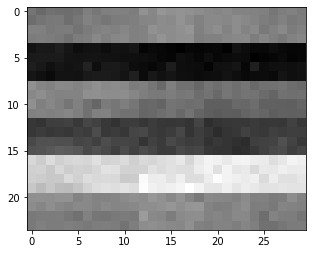

<Figure size 432x288 with 0 Axes>

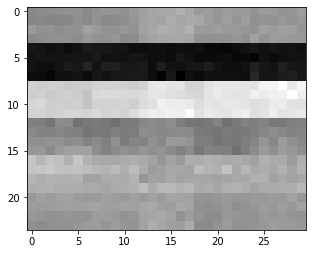

<Figure size 432x288 with 0 Axes>

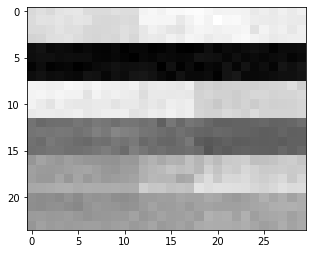

<Figure size 432x288 with 0 Axes>

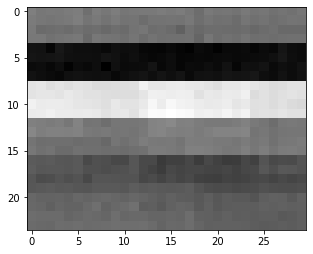

<Figure size 432x288 with 0 Axes>

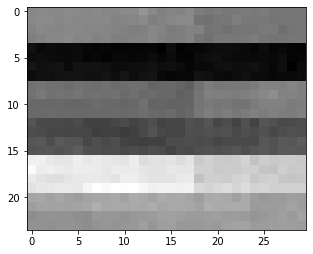

<Figure size 432x288 with 0 Axes>

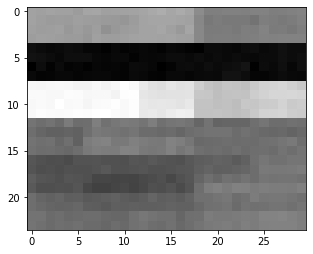

<Figure size 432x288 with 0 Axes>

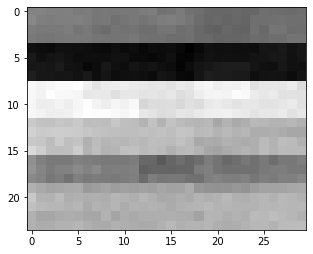

<Figure size 432x288 with 0 Axes>

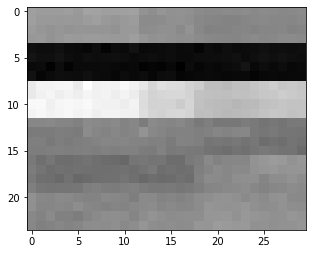

<Figure size 432x288 with 0 Axes>

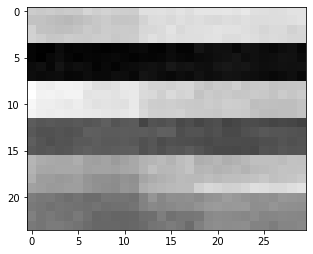

<Figure size 432x288 with 0 Axes>

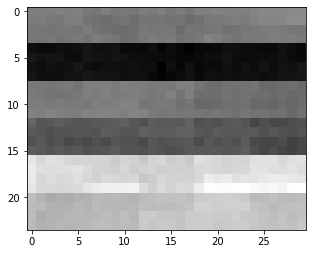

<Figure size 432x288 with 0 Axes>

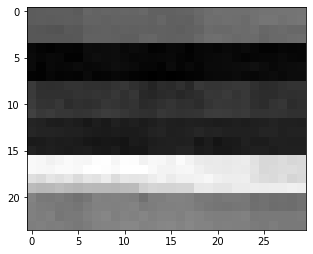

<Figure size 432x288 with 0 Axes>

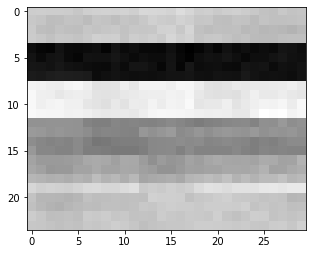

<Figure size 432x288 with 0 Axes>

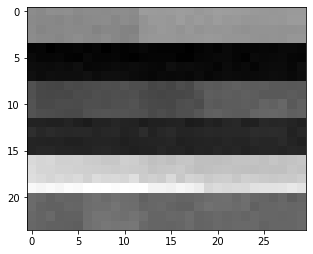

<Figure size 432x288 with 0 Axes>

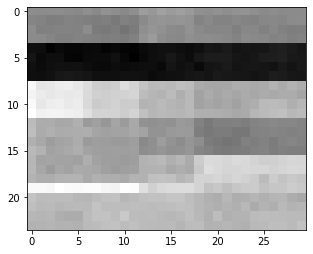

<Figure size 432x288 with 0 Axes>

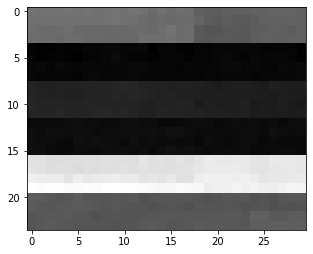

<Figure size 432x288 with 0 Axes>

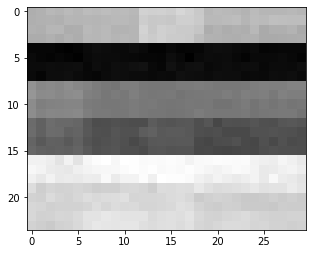

<Figure size 432x288 with 0 Axes>

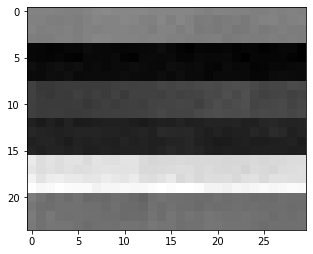

<Figure size 432x288 with 0 Axes>

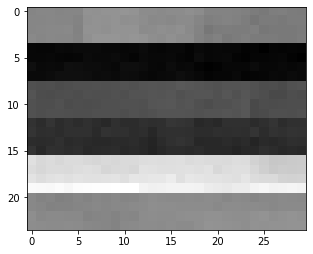

<Figure size 432x288 with 0 Axes>

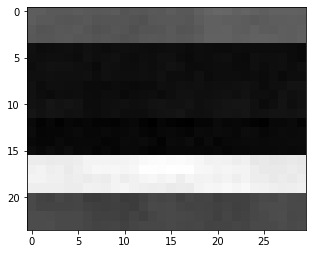

<Figure size 432x288 with 0 Axes>

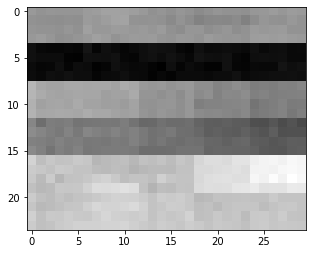

<Figure size 432x288 with 0 Axes>

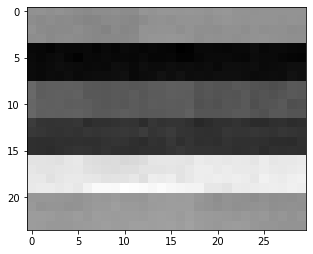

<Figure size 432x288 with 0 Axes>

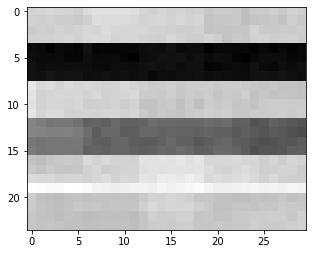

<Figure size 432x288 with 0 Axes>

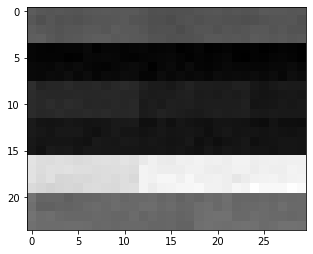

<Figure size 432x288 with 0 Axes>

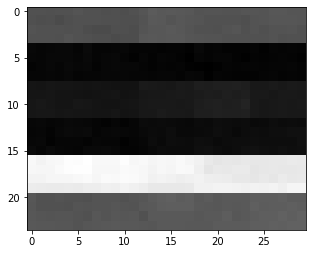

<Figure size 432x288 with 0 Axes>

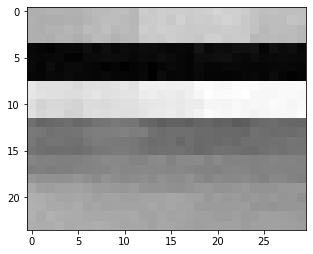

<Figure size 432x288 with 0 Axes>

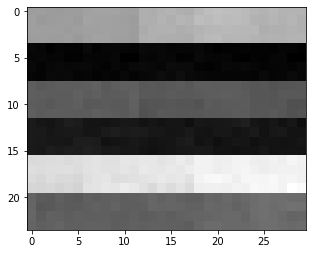

<Figure size 432x288 with 0 Axes>

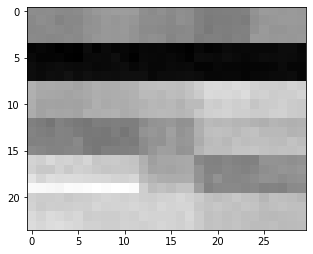

<Figure size 432x288 with 0 Axes>

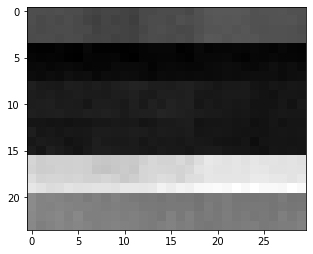

<Figure size 432x288 with 0 Axes>

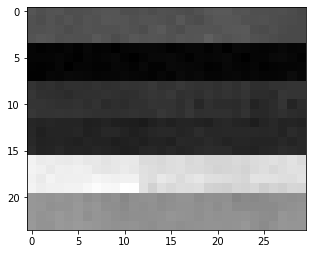

<Figure size 432x288 with 0 Axes>

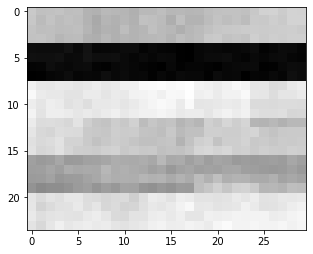

<Figure size 432x288 with 0 Axes>

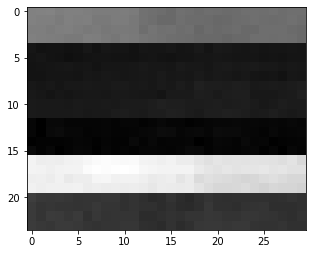

<Figure size 432x288 with 0 Axes>

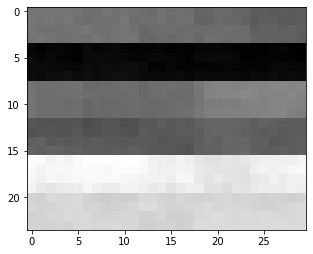

<Figure size 432x288 with 0 Axes>

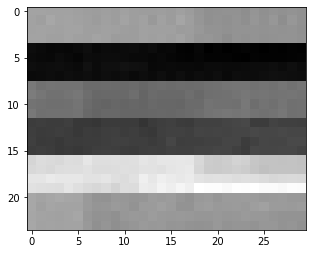

<Figure size 432x288 with 0 Axes>

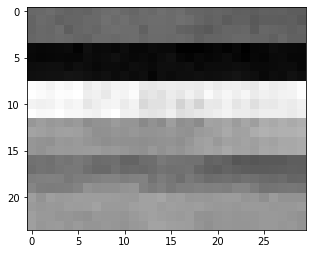

<Figure size 432x288 with 0 Axes>

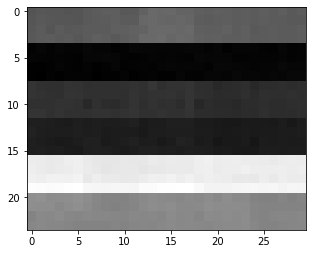

<Figure size 432x288 with 0 Axes>

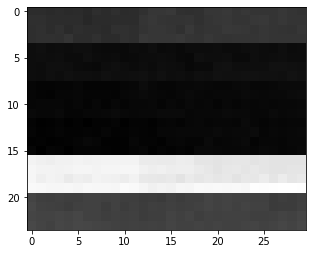

<Figure size 432x288 with 0 Axes>

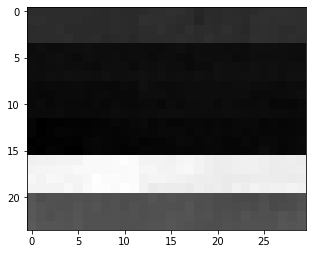

<Figure size 432x288 with 0 Axes>

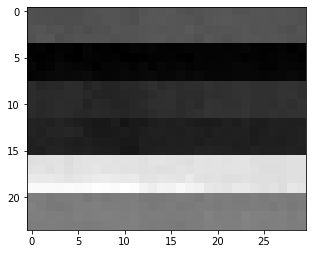

<Figure size 432x288 with 0 Axes>

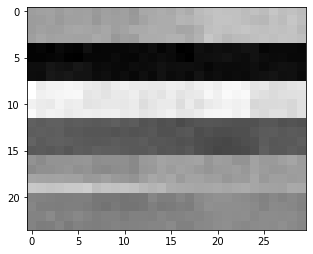

<Figure size 432x288 with 0 Axes>

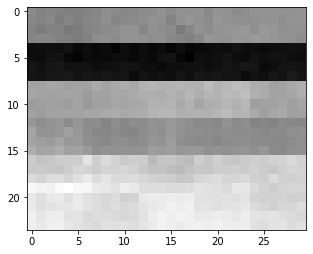

<Figure size 432x288 with 0 Axes>

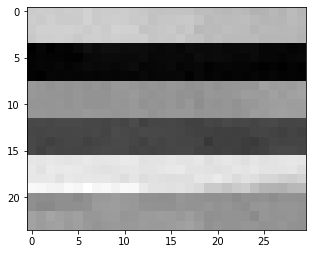

<Figure size 432x288 with 0 Axes>

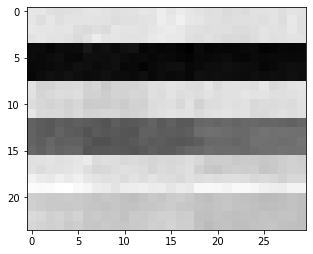

<Figure size 432x288 with 0 Axes>

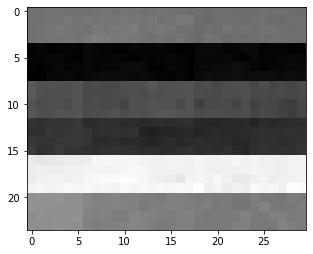

<Figure size 432x288 with 0 Axes>

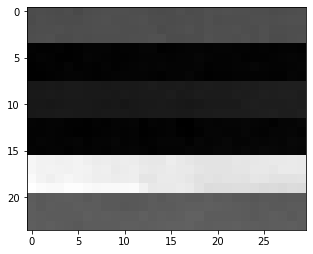

<Figure size 432x288 with 0 Axes>

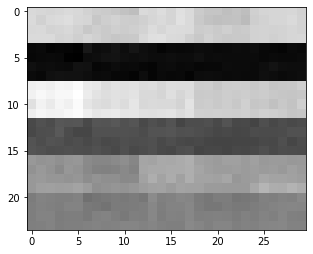

<Figure size 432x288 with 0 Axes>

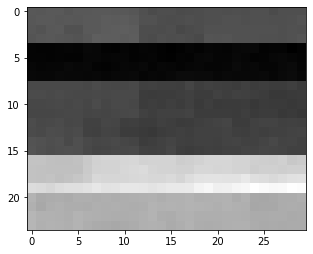

<Figure size 432x288 with 0 Axes>

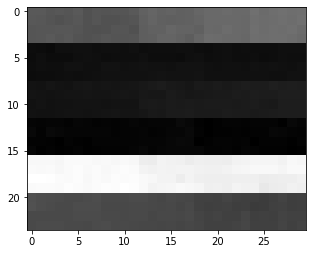

<Figure size 432x288 with 0 Axes>

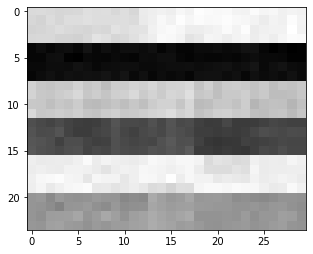

<Figure size 432x288 with 0 Axes>

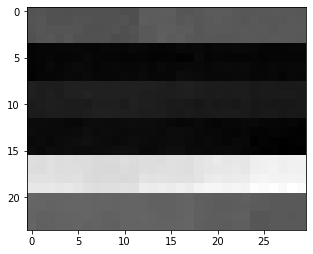

<Figure size 432x288 with 0 Axes>

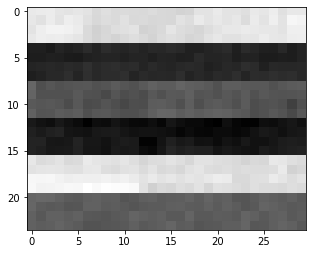

<Figure size 432x288 with 0 Axes>

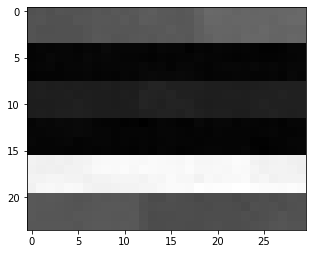

<Figure size 432x288 with 0 Axes>

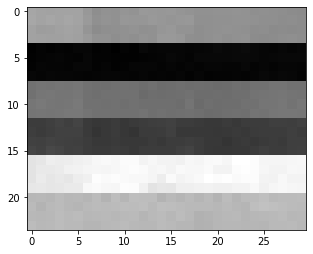

<Figure size 432x288 with 0 Axes>

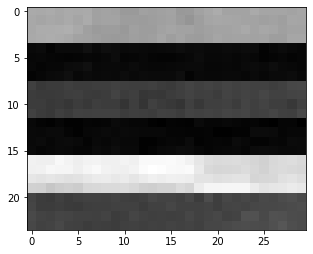

<Figure size 432x288 with 0 Axes>

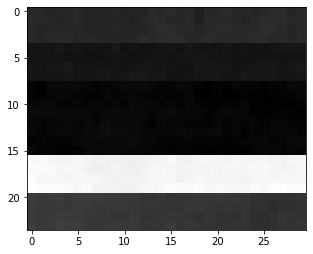

<Figure size 432x288 with 0 Axes>

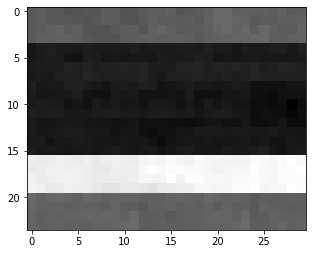

<Figure size 432x288 with 0 Axes>

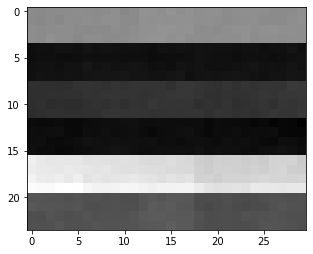

<Figure size 432x288 with 0 Axes>

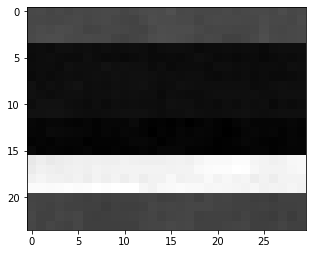

<Figure size 432x288 with 0 Axes>

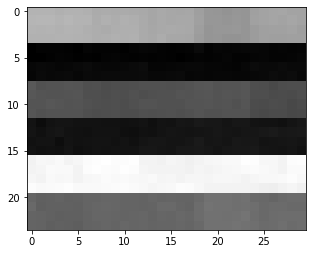

<Figure size 432x288 with 0 Axes>

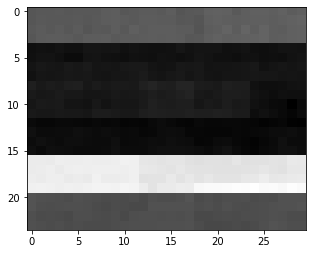

<Figure size 432x288 with 0 Axes>

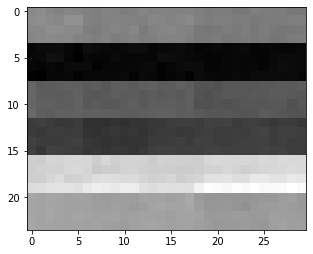

<Figure size 432x288 with 0 Axes>

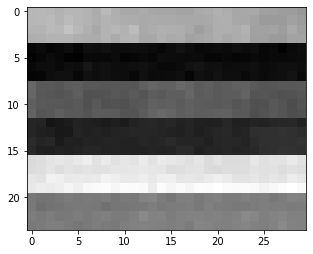

<Figure size 432x288 with 0 Axes>

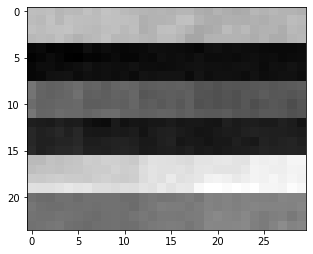

<Figure size 432x288 with 0 Axes>

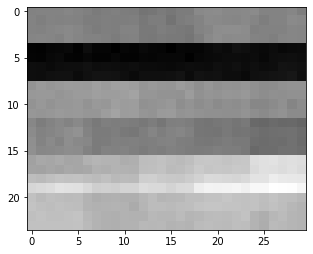

<Figure size 432x288 with 0 Axes>

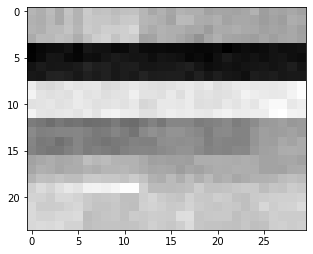

<Figure size 432x288 with 0 Axes>

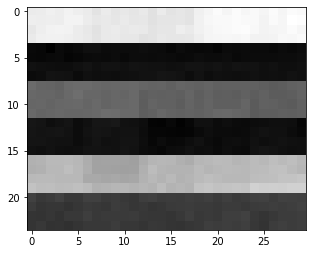

<Figure size 432x288 with 0 Axes>

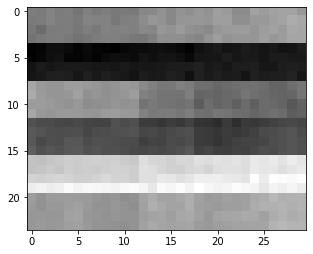

<Figure size 432x288 with 0 Axes>

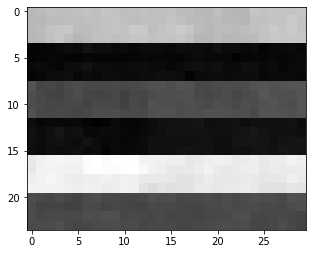

<Figure size 432x288 with 0 Axes>

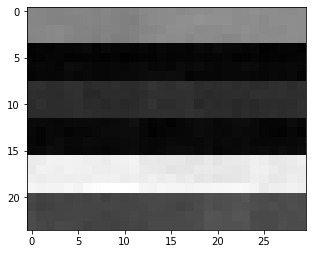

<Figure size 432x288 with 0 Axes>

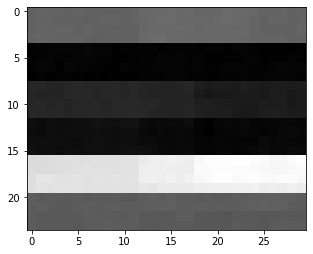

<Figure size 432x288 with 0 Axes>

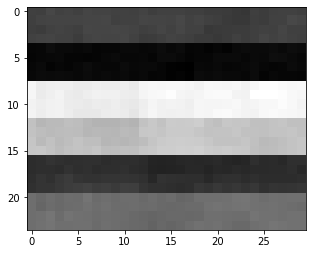

<Figure size 432x288 with 0 Axes>

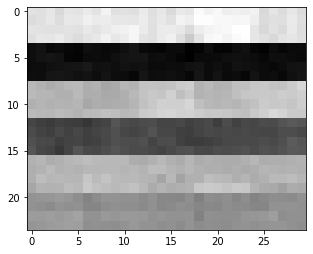

<Figure size 432x288 with 0 Axes>

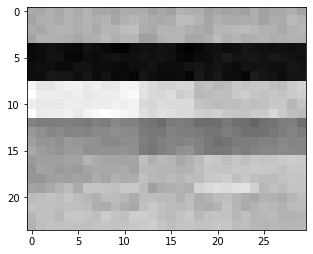

<Figure size 432x288 with 0 Axes>

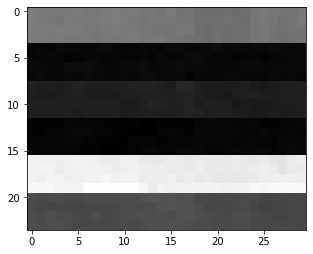

<Figure size 432x288 with 0 Axes>

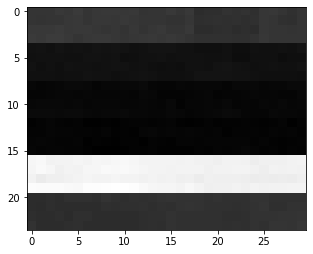

<Figure size 432x288 with 0 Axes>

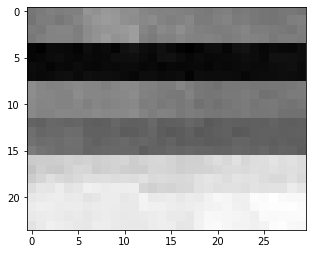

<Figure size 432x288 with 0 Axes>

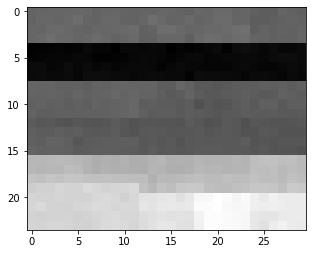

<Figure size 432x288 with 0 Axes>

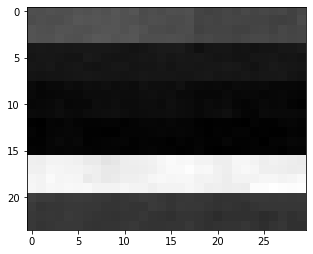

<Figure size 432x288 with 0 Axes>

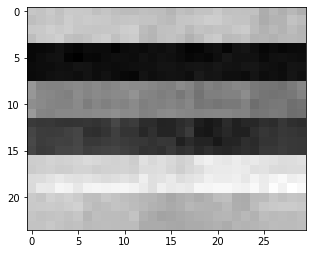

<Figure size 432x288 with 0 Axes>

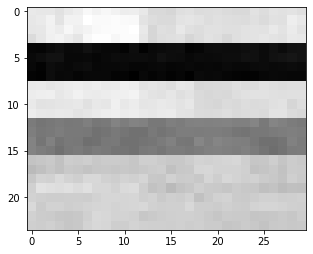

<Figure size 432x288 with 0 Axes>

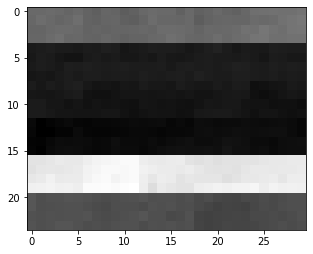

<Figure size 432x288 with 0 Axes>

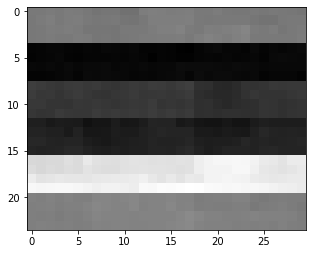

<Figure size 432x288 with 0 Axes>

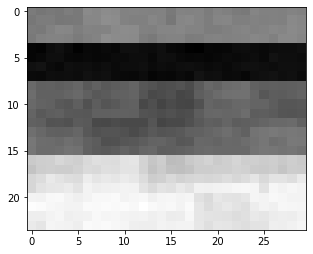

<Figure size 432x288 with 0 Axes>

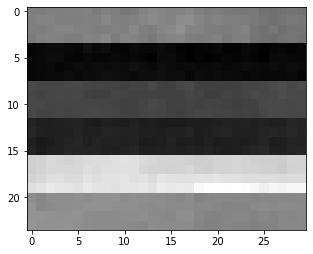

<Figure size 432x288 with 0 Axes>

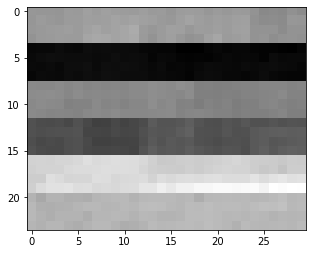

<Figure size 432x288 with 0 Axes>

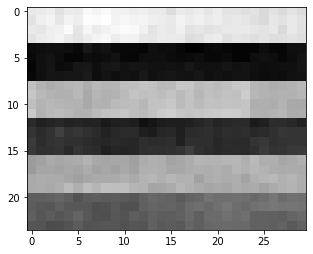

<Figure size 432x288 with 0 Axes>

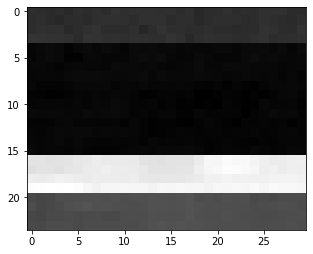

<Figure size 432x288 with 0 Axes>

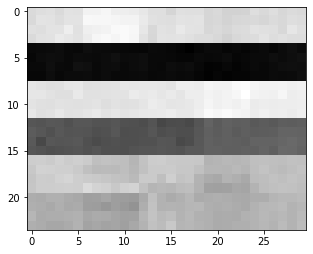

<Figure size 432x288 with 0 Axes>

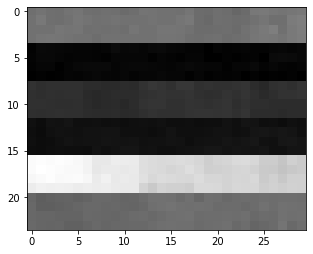

<Figure size 432x288 with 0 Axes>

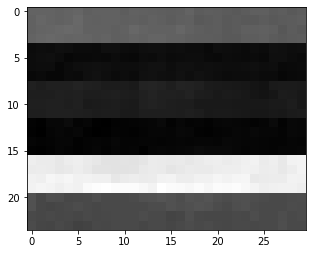

<Figure size 432x288 with 0 Axes>

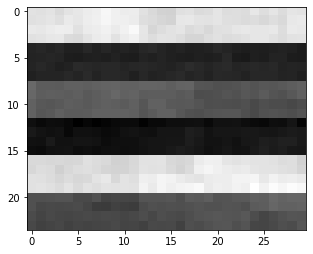

<Figure size 432x288 with 0 Axes>

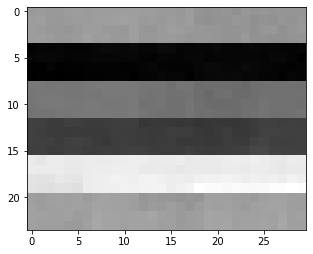

<Figure size 432x288 with 0 Axes>

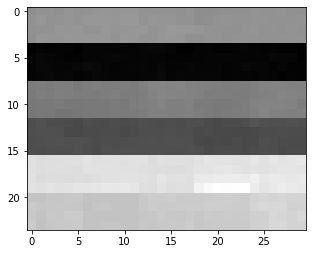

<Figure size 432x288 with 0 Axes>

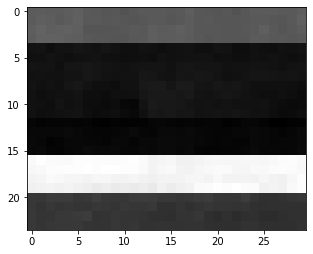

<Figure size 432x288 with 0 Axes>

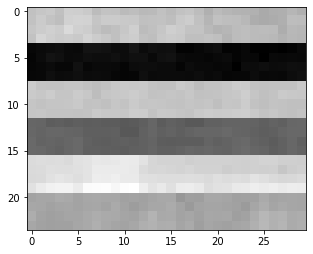

<Figure size 432x288 with 0 Axes>

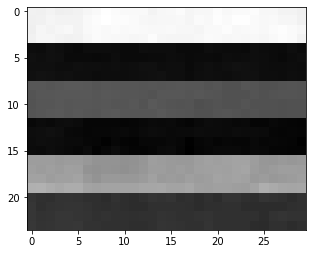

<Figure size 432x288 with 0 Axes>

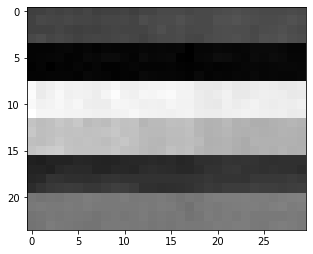

<Figure size 432x288 with 0 Axes>

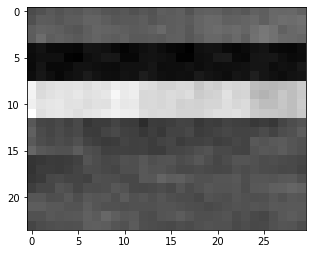

<Figure size 432x288 with 0 Axes>

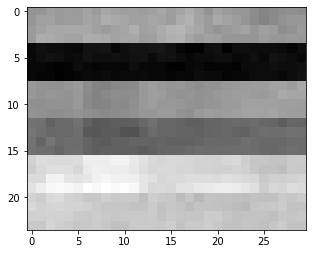

<Figure size 432x288 with 0 Axes>

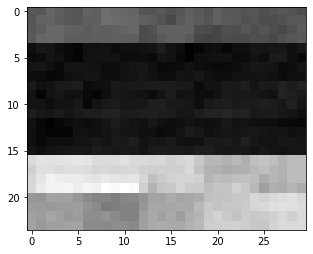

<Figure size 432x288 with 0 Axes>

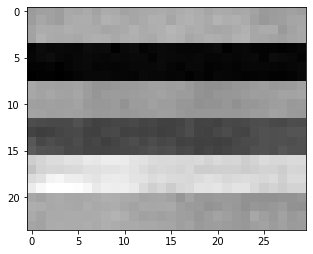

In [10]:
model.train_model(
    x_train = data_alt_3_4,     
    keep_prob = 0.5, #0.5
    train_epoch = 5000, #17000
    n_critic = 5,#5
    step_valid = 50, #50
    step_save_data = 500, #500
    iteration_generator = 400,
    )

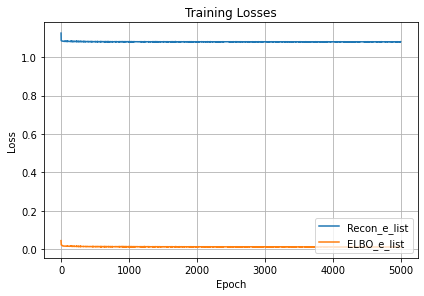

In [11]:
model.show_train_hist()

# Generating data

In [12]:
# class election_GAN_GEN(object):
#     def __init__(self,
#                 dim_height = None,
#                 dim_width = None,
#                 dim_z = None,
#                 num_class = None,
#                 batch_size = None,):
        
#         # Definition Params:
#         self.dim_height = dim_height    
#         self.dim_width = dim_width  
#         self.dim_z = dim_z    
#         self.num_class = num_class      
#         self.batch_size = batch_size  

#         # Define Network Input:
#         self.Z = tf.placeholder(tf.float32, shape=(None, 1, 1, self.dim_z))
#         self.Y_label = tf.placeholder(tf.float32, shape=(None, 1, 1, self.num_class))

#         # Network:
#         self._GEN(self.Z, self.Y_label)

#         # get the generated data
#         with tf.variable_scope('object_cost_function', reuse=tf.AUTO_REUSE):
#             self.call_GEN()
        
#     def _GEN(self, Z, Y_label):            
#         keep_prob_feed = 1
#         isTrain=False 
#         dim = 128
        
#         with tf.variable_scope("GEN", reuse=False):
#             # concat layer
#             Z_ = tf.concat([Z, Y_label], 3)  #(batch_szie, 1, 1, dim_z + num_class)
#             Z_ = tf.reshape(Z_, (-1, self.dim_z + self.num_class))        

#             # FCN 
#             hidden = tf.layers.dense(Z_, units = 2*2*3*dim)
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
#             hidden = tf.nn.relu(hidden)
#             hidden = tf.reshape(hidden, (-1, 2, 2, 3*dim)) 

#             # CNN 1 
#             hidden = tf.layers.conv2d_transpose(hidden, 2*dim, [3, 3], strides=(1, 2), padding='valid')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
#             hidden = tf.nn.relu(hidden)

#             # CNN 2 
#             hidden = tf.layers.conv2d_transpose(hidden, 1*dim, [3, 3], strides=(3, 3), padding='same')
#             hidden = tf.layers.batch_normalization(hidden, training=isTrain)
#             hidden = tf.nn.relu(hidden)     

#             # CNN 3 
#             hidden = tf.layers.conv2d_transpose(hidden, 1, [3, 3], strides=(2, 2), padding='same')         
#             output = hidden

#             return output     
    
#     def call_GEN(self):
#         self.fake_output = self._GEN(self.Z, self.Y_label)

#     def GEN_model(self, path, iteration): 
    
#         saver = tf.train.Saver()

#         gpu_options = tf.GPUOptions(allow_growth=True)
#         with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
#             saver.restore(sess, tf.train.latest_checkpoint(path))      
            
#             generated_3alt = []
#             generated_4alt = []  
            
#             for _ in range(iteration): 
#                 '''#############        Generator          #######################'''
#                 ############        num_alternative = 3      #######################
#                 z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
#                 y_ = np.zeros([self.batch_size, 1]) + 0
#                 y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

#                 output_g_alt3 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})    
#                 output_g_alt3_ = np.array(output_g_alt3).reshape([self.batch_size, self.dim_height, self.dim_width])
#                 generated_3alt.append(output_g_alt3_)
                
#                 ############        num_alternative = 4      #######################
#                 z_ = np.random.normal(0, 1, (self.batch_size, 1, 1, self.dim_z))   
#                 y_ = np.zeros([self.batch_size, 1]) + 1
#                 y_label_ = one_hot(y_, self.num_class).reshape([self.batch_size, 1, 1, self.num_class])

#                 output_g_alt4 = sess.run([self.fake_output], feed_dict={self.Z: z_, self.Y_label: y_label_})  
#                 output_g_alt4_ = np.array(output_g_alt4).reshape([self.batch_size, self.dim_height, self.dim_width])
#                 generated_4alt.append(output_g_alt4_)

#             generated_3alt = np.array(generated_3alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
#             generated_4alt = np.array(generated_4alt).reshape([iteration*self.batch_size, self.dim_height, self.dim_width])
                
#             return generated_3alt, generated_4alt

In [13]:
# tf.reset_default_graph()

In [14]:
# generator = election_GAN_GEN(
#                 dim_height = dim_height,
#                 dim_width = dim_width,
#                 dim_z = dim_z,
#                 num_class = num_class,
#                 batch_size = batch_size)


shape[0]: number of generated data

shape[1], shape[2]: data size before resize back to original size

In [15]:
# iteration_generator = 50
# gen_alt3, gen_alt4 = generator.GEN_model(path = restore_path, 
#                                          iteration = iteration_generator) #iteration: how many times generator is used?
# print(gen_alt3.shape) 
# print(gen_alt4.shape)

In [16]:
# plt.figure(1)
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(gen_alt3[0], (dim_height, dim_width)), cmap='gray')

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.cla()
# ax.imshow(np.reshape(gen_alt4[0], (dim_height, dim_width)), cmap='gray')            
# plt.show()

# Resize to original shpe & Save as CSV

In [17]:
# def resize_to_ori(x, img_size, img_width, img_height, ori_size):
#     x = x.reshape([iteration_generator*batch_size, img_width*img_height])
#     cell_size = int(img_size//ori_size)

#     ori_dat = []
#     for j in range(x.shape[0]):
#         dat = x[j]
#         tmp = []
#         for i in range(dat.shape[0] // cell_size):
#             k = dat[(i)*cell_size:(i+1)*cell_size]
#             tmp.append(np.mean(k))
#         ori_dat.append(tmp)
#     ori_dat = np.array(ori_dat)    
#     return ori_dat

In [18]:
# img_size = np.math.factorial(6)
# img_width = 30
# img_height = 24
# ori_size = np.math.factorial(3)

# gen_alt3_ori = resize_to_ori(gen_alt3, img_size, img_width, img_height, ori_size)
# gen_alt3_pd = pd.DataFrame(gen_alt3_ori, columns = ['ABC', 'ACB', 'BAC', 'BCA', 'CAB', 'CBA'])
# print(gen_alt3_pd.shape)
# gen_alt3_pd.head()

In [19]:
# gen_alt3_pd.to_csv(generated_path + 'generated_atl3.csv')

In [20]:
# img_size = np.math.factorial(6)
# img_width = 30
# img_height = 24
# ori_size = np.math.factorial(4)

# gen_alt4_ori = resize_to_ori(gen_alt4, img_size, img_width, img_height, ori_size)
# gen_alt4_pd = pd.DataFrame(gen_alt4_ori, columns = ['ABCD', 'ACBD', 'BACD', 'BCAD', 'CABD', 'CBAD', 'DABC',
#        'DACB', 'DBAC', 'DBCA', 'DCAB', 'DCBA', 'ADBC', 'ADCB', 'BDAC', 'BDCA',
#        'CDAB', 'CDBA', 'ABDC', 'ACDB', 'BADC', 'BCDA', 'CADB', 'CBDA'])
# print(gen_alt4_pd.shape)
# gen_alt4_pd.head()

In [21]:
# gen_alt4_pd.to_csv(generated_path + 'generated_atl4.csv')